<a href="https://colab.research.google.com/github/Mgalvaz/digit-recognizer/blob/main/train_quantum_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install qiskit==1.4.3 qiskit-machine-learning==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567861 sha256=8a79bc86ddd66d9c1bbb2d1ac7ff5c52473addb12963fda43a348f2d10bfd4f6
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [15]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.utils.loss_functions import L2Loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [22]:
# Get a portion of the MNIST dataset and reduce the number of features
def preprocess_data(input_features, output_qubits, size_train=2000, test=0.25):
  size_test = int(size_train * test)
  (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
  train_images = train_images.reshape((train_images.shape[0], -1)) / 255.0
  test_images = test_images.reshape((test_images.shape[0], -1)) / 255.0

  scaler = StandardScaler()
  train_images = scaler.fit_transform(train_images)
  test_images = scaler.transform(test_images)

  pca = PCA(n_components=input_features)
  train_images = pca.fit_transform(train_images)
  test_images = pca.transform(test_images)

  train_images = train_images * 2 * np.pi
  test_images = test_images * 2 * np.pi

  if output_qubits == 4:
    # Map a number from 0 to 9 to its binary representation of 4 bits, and then each 0 to 1 and each 1 to -1
    train_labels = 1 - 2*np.array([list(map(int, format(label, '04b'))) for label in train_labels])
    test_labels = 1 - 2*np.array([list(map(int, format(label, '04b'))) for label in test_labels])

  return (train_images[:size_train], train_labels[:size_train]), (test_images[:size_test], test_labels[:size_test])

In [28]:
def denseZZ_feature_map(num_features, param_name):
  num_qubits = num_features // 2
  qc = QuantumCircuit(num_qubits, name='Encoding')
  x = ParameterVector(param_name, length=num_features)
  for i in range(num_qubits):
      qc.ry(x[2 * i], i)
      qc.rz(x[2 * i + 1], i)
  for i in range(num_qubits - 1):
      qc.cx(i, i + 1)
      qc.p(2 * (-np.pi + x[2 * i + 3]) * (-np.pi + x[2 * i + 1]), i + 1)
      qc.cx(i, i + 1)
  if num_qubits > 0:
      qc.cx(num_qubits - 1, 0)
      qc.p(2 * (-np.pi + x[1]) * (-np.pi + x[2 * num_qubits - 1]), 0)
      qc.cx(num_qubits - 1, 0)
  qc_inst = qc.to_instruction()
  qc = QuantumCircuit(num_qubits)
  qc.append(qc_inst, range(num_qubits))
  return qc

def pool_circuit(origin, target, param_name):
  if len(origin) != len(target):
      raise ValueError('origin and target must be of the same length')
  num_qubits = len(origin) + len(target)
  params = ParameterVector(param_name, length=num_qubits // 2 * 3)
  qc = QuantumCircuit(num_qubits, name='Pooling Layer')
  for i, (o, t) in enumerate(zip(origin, target)):
      qc.rz(-np.pi / 2, t)
      qc.cx(t, o)
      qc.rz(params[3 * i], o)
      qc.ry(params[3 * i + 1], t)
      qc.cx(o, t)
      qc.ry(params[3 * i + 2], t)
  qc_inst = qc.to_instruction()
  qc = QuantumCircuit(num_qubits)
  qc.append(qc_inst, range(num_qubits))
  return qc

def convolutional_circuit(num_qubits, parameter_name):
  qc = QuantumCircuit(num_qubits, name='Convolutional Layer')
  qc.compose(efficient_su2(num_qubits, reps=2, parameter_prefix=parameter_name))
  qc_inst = qc.to_instruction()
  qc = QuantumCircuit(num_qubits)
  qc.append(qc_inst, range(num_qubits))
  return qc

In [29]:
# Function that will execute at the end of each iteration
def callback_func(weights, loss):
  losses.append(loss)
  if len(losses)%10 == 0:
    clear_output(wait=True)
    plt.title("Loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(losses)), losses)
    plt.show()

def interpreter(x):
  #return int(format(x, '04b')[-4:], base=2)
  return int(str(x)[0])

def cost_func_domain(weights):
    predictions = qnne.forward(train_x, weights)
    cost = np.mean(mse(predictions, train_y))
    callback_func(weights, cost)
    return cost

In [30]:
# Feature map to encode classical data into qubits
feature_map = denseZZ_feature_map(16, 'x')

# VQC ansatz composed of convolutional with pooling layers
ansatz = QuantumCircuit(8)
ansatz.compose(convolutional_circuit(8, 'c1'), range(8), inplace=True)
ansatz.compose(pool_circuit(range(4), range(4, 8), 'p1'), range(8), inplace=True)
ansatz.compose(convolutional_circuit(4, 'c2'), range(4, 8), inplace=True)

# Full circuit
QCNN = QuantumCircuit(8)
QCNN.compose(feature_map, range(8), inplace=True)
QCNN.compose(ansatz, range(8), inplace=True)

observables = []
for i in range(4):
    obs = SparsePauliOp.from_list([('I'*i + 'Z' + 'I'*(7-i), 1)])
    observables.append(obs)

qnne = EstimatorQNN(
    circuit=QCNN.decompose(),
    estimator=Estimator(),
    observables=observables,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    gradient=ParamShiftEstimatorGradient(Estimator()),
    num_virtual_qubits=8
)

qnns = SamplerQNN(
  circuit=QCNN.decompose(),
  input_params=feature_map.parameters,
  weight_params=ansatz.parameters,
  interpret=interpreter,
  output_shape=10,
  sampler=Sampler()
)

vqc = VQC(
    sampler=Sampler(),
    feature_map=feature_map.decompose(),
    ansatz=ansatz.decompose(),
    optimizer=COBYLA(maxiter=150),
    callback=callback_func,
)

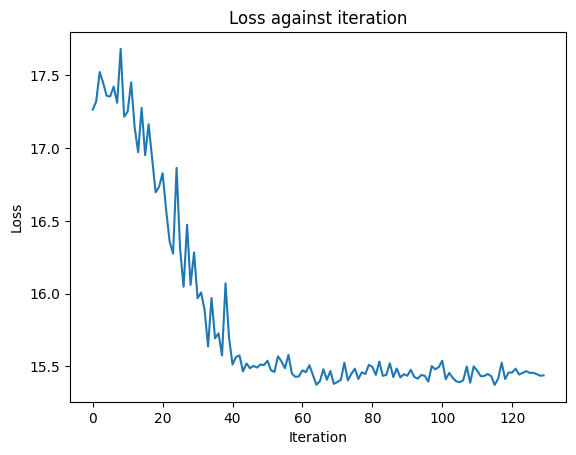

0.04

In [ ]:
losses = []
classifier = NeuralNetworkClassifier(qnns, optimizer=COBYLA(maxiter=150), callback=callback_func)
(train_x, train_y), (test_x, test_y) = preprocess_data(16, 0, size_train=100)

classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

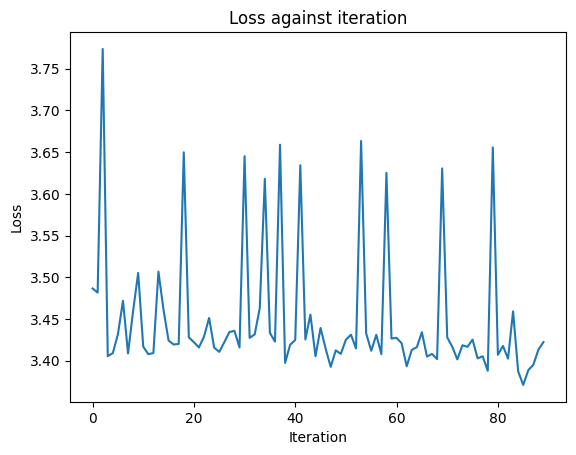

0.08

In [ ]:
losses = []
(train_x, train_y), (test_x, test_y) = preprocess_data(16, 0, size_train=100)
vqc.fit(train_x, train_y)
vqc.score(test_x, test_y)


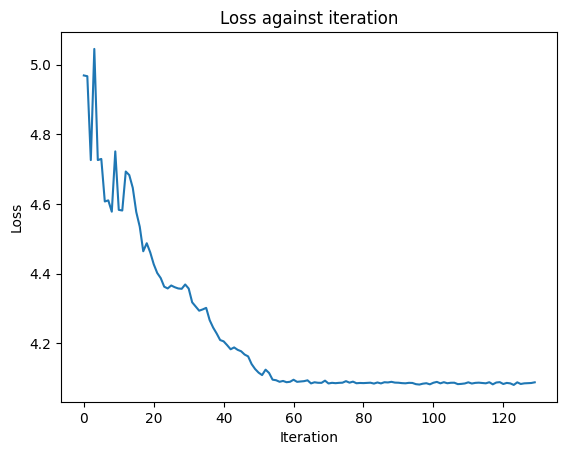

0.05


In [31]:
losses = []
optimizer = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(qnne.num_weights)
mse = L2Loss()
(train_x, train_y), (test_x, test_y) = preprocess_data(16, 4, size_train=1000)
opt_result = optimizer.minimize(cost_func_domain, initial_point)
print(f'{np.sum(np.all(np.sign(qnne.forward(test_x, opt_result.x)) == test_y, axis=1))/len(test_y):.2f}')